# Classification with XGBoost

We build a classification model for risk
assessment of loan default analyzing the synthetic data-set available on the [Kaggle
website](https://www.kaggle.com/datasets/udaymalviya/bank-loan-data).
The goal is to predict whether a given person will be able to repay or not a given
loan. We will then compare the model with the results obtained using logistic regression
that are posted on the website.

## Data preparation

See the columns, their data type, and whether it has missing values in table below.
We can see that we have floats, integers, and texts,
representing categorical variables, and that there are no missing values.

In [1]:
from itertools import product

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import xgboost as xgb
import sklearn
from sklearn.model_selection import cross_val_score, RandomizedSearchCV, train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_score, accuracy_score, recall_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

def dtype_and_nans_summary(df: pd.DataFrame) -> pd.DataFrame:
    summary = pd.DataFrame({
        'dtype': df.dtypes.astype(str),
        'has_na': df.isna().any()
    })

    numeric_cols = df.select_dtypes(include='number').columns

    summary['min'] = df[numeric_cols].min()
    summary['max'] = df[numeric_cols].max()
    summary['mean'] = df[numeric_cols].mean()
    summary['median'] = df[numeric_cols].median()

    return summary


def drop_extreme_1_percent(df: pd.DataFrame) -> pd.DataFrame:
    df_trimmed = df.copy()
    numeric_cols = df.select_dtypes(include='number').columns

    for col in numeric_cols:
        lower = df[col].quantile(0.01)
        upper = df[col].quantile(0.99)
        df_trimmed = df_trimmed[(df_trimmed[col] >= lower) & (df_trimmed[col] <= upper)]

    return df_trimmed

def get_version_info():
    print("Pandas version:", pd.__version__)
    print("NumPy version:", np.__version__)
    print("XGBoost version:", xgb.__version__)
    print("Scikit-learn version:", sklearn.__version__)
    print("Python version:", pd.__version__)

get_version_info()

Pandas version: 2.2.2
NumPy version: 1.26.4
XGBoost version: 3.0.0
Scikit-learn version: 1.6.1
Python version: 2.2.2


In [2]:
loans_raw = pd.read_csv("loan_data.csv")
loans_raw.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [3]:
dtype_and_nans_summary(loans_raw)

,dtype,has_na,min,max,mean,median
person_age,float64,False,20.00,144.00,27.764178,26.00
person_gender,object,False,NaN,NaN,NaN,NaN
person_education,object,False,NaN,NaN,NaN,NaN
person_income,float64,False,8000.00,7200766.00,80319.053222,67048.00
person_emp_exp,int64,False,0.00,125.00,5.410333,4.00
person_home_ownership,object,False,NaN,NaN,NaN,NaN
loan_amnt,float64,False,500.00,35000.00,9583.157556,8000.00
loan_intent,object,False,NaN,NaN,NaN,NaN
loan_int_rate,float64,False,5.42,20.00,11.006606,11.01
loan_percent_income,float64,False,0.00,0.66,0.139725,0.12


We can see that there may be some data quality issues, as somebody has reached the age of 144.
To treat outliers, we drop numerical entries which are in the first or last 1% of the
distribution.

We believe that the most important features are

1. `credit_score`: the credit score of the person  
2. `person_income`: the income of the person  
3. `loan_amnt`: the amount of the loan  
4. `loan_int_rate`: the interest rate of the loan  
5. `person_age`: the age of the person  

We believe that credit score is the most important feature, as it is a measure of the
creditworthiness of the person, defined by corporates as a single metric that should be the most relevant.
Credit history and previous defaults are already captured by this score.

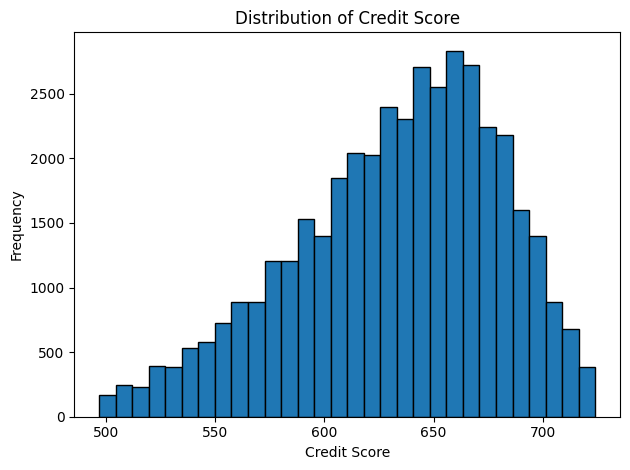

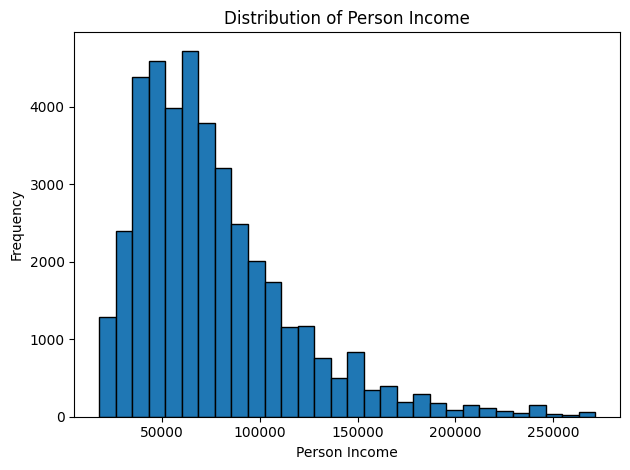

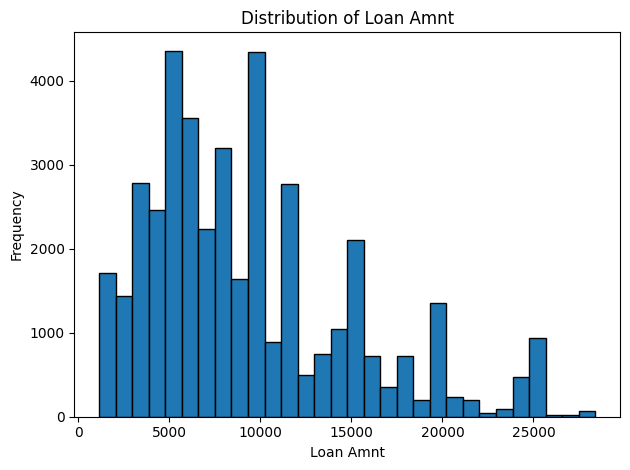

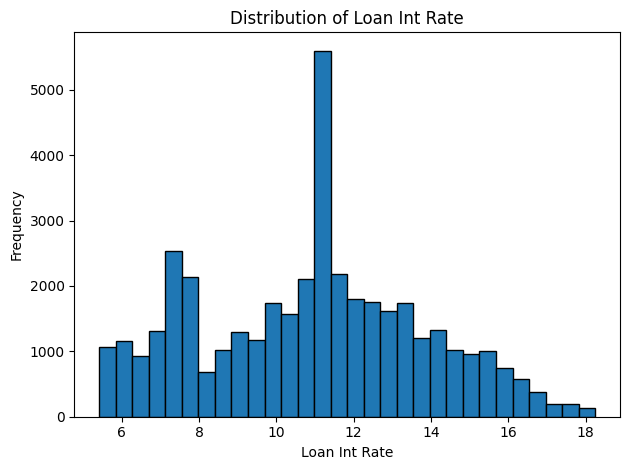

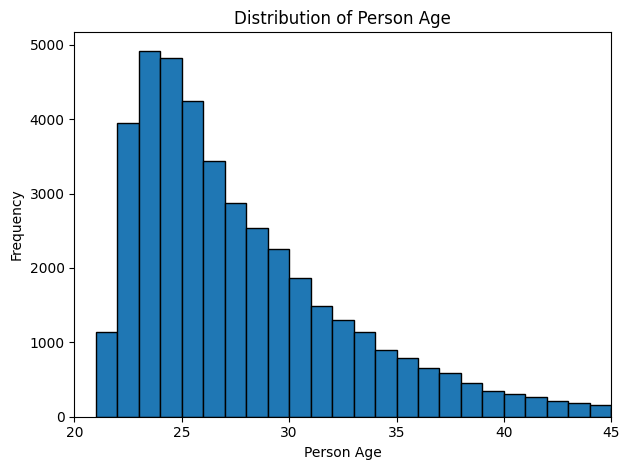

In [4]:
loans = drop_extreme_1_percent(loans_raw)

columns = ["credit_score", "person_income", "loan_amnt", "loan_int_rate", "person_age"]

for col in columns:
    plt.figure()
    if col == "person_age":
            age_data = loans[col]
            bins = sorted(age_data.unique())
            age_data.hist(bins=bins, edgecolor='black')
            plt.xlim(20, 45)
    else:
        loans[col].hist(bins=30, edgecolor='black')
    
    plt.title(f"Distribution of {col.replace('_', ' ').title()}")
    plt.xlabel(col.replace('_', ' ').title())
    plt.ylabel("Frequency")
    plt.grid(False)
    plt.tight_layout()


### Categorical variables
We have categorical variables that need to be converted to numerical
variables. XGBoost can handle categorical variables,
and we will fully rely on its features.
What we need to do is to convert the columns with data type `object` to `category`.

Alternatively, we could define new columns for each of the categorical variables, and assign them
a value of 1 if the person belongs to that category, and 0 otherwise. Pandas has a
built-in function to do this, called `get_dummies`. 

In [5]:
categorical_columns = loans.select_dtypes(include="object").columns.tolist()
loans_c = loans.copy()
loans_c[categorical_columns] = loans_c[categorical_columns].astype("category")

## Train the model with XGBoost

We will use the `XGBClassifier` class from the `xgboost` library to train the model.
There are many hyperparameters that can be tuned, and we will do a brute-force
search to find the best combination of hyperparameters.
The search will be done around the default values of the hyperparameters.
We can see that there is no significant difference between the default values and the
values we found with the random search. We split the data into training and test sets,
and we will use the training set to train the model and the test set to evaluate the
model after cross-validation. I.e. we split the training set into 5 folds, and we will
use 4 folds to train the model and 1 fold to evaluate the model for the hyperparameter
search.

We didn't search through all the hyperparameters, e.g. subsample and colsample_bytree,
because they were not among the most popular ones in other ML samples,
but we will do another search including all the hyperparameters later.
These unspecified parameters are then will have the default values as defined in the XGBoost library, which is 1.

The best parameteres on the subset of training sets,
and best hyperparameters on the whole training set are then
evaluated on the test set for ROC.

In [40]:
X = loans_c.drop(columns="loan_status")
y = loans_c["loan_status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

param_grid = {
    "max_depth": [3, 5, 7],
    "learning_rate": [0.01, 0.1],
    "min_child_weight": [1, 3],
    "n_estimators": [100, 300]
}

param_combinations = list(product(
    param_grid["max_depth"],
    param_grid["learning_rate"],
    param_grid["min_child_weight"],
    param_grid["n_estimators"]
))

results = []

for max_depth, learning_rate, min_child_weight, n_estimators in param_combinations:
    model = xgb.XGBClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        min_child_weight=min_child_weight,
        n_estimators=n_estimators,
        tree_method="hist",
        enable_categorical=True,
        eval_metric="logloss"
    )
    
    score = cross_val_score(model, X_train, y_train, cv=5, scoring="accuracy").mean()
    
    results.append({
        "max_depth": max_depth,
        "learning_rate": learning_rate,
        "min_child_weight": min_child_weight,
        "n_estimators": n_estimators,
        "cv_accuracy": score
    })

results_df = pd.DataFrame(results)



In [41]:
results_df.sort_values(by="cv_accuracy", ascending=False)

,max_depth,learning_rate,min_child_weight,n_estimators,cv_accuracy
23,7,0.10,3,300,0.930579
13,5,0.10,1,300,0.930002
15,5,0.10,3,300,0.929547
21,7,0.10,1,300,0.929122
7,3,0.10,3,300,0.928151
20,7,0.10,1,100,0.928090
22,7,0.10,3,100,0.927483
5,3,0.10,1,300,0.927422
14,5,0.10,3,100,0.925631
12,5,0.10,1,100,0.925206


### Preliminary weights

On this brute-force search grid, we found an optimal set of hyperparameters that gives us a good
performance on the test set. Given these hyperparameters,
we can see what the weights will be for the best and worst 2 set of hyperparameters.
The weights are the number of times each feature is used to split the data,
so it depends on how many nodes were created, which is affected by the hyperparameter
That's why the total number of weights are not the same accross different hyperparameter sets.
We hope that the weights do not depend too much on the hyperparameters.

In [ ]:
top2 = results_df.sort_values("cv_accuracy", ascending=False).head(2).reset_index(drop=True)
low2 = results_df.sort_values("cv_accuracy", ascending=False).tail(2).reset_index(drop=True)
joined = pd.concat([top2, low2], ignore_index=True)
all_features = X_train.columns.tolist()
importance_rows = []

for i, row in joined.iterrows():
    model = xgb.XGBClassifier(
        max_depth=int(row["max_depth"]),
        learning_rate=float(row["learning_rate"]),
        min_child_weight=int(row["min_child_weight"]),
        n_estimators=int(row["n_estimators"]),
        tree_method="hist",
        enable_categorical=True,
        eval_metric="logloss"
    )
    model.fit(X_train, y_train)

    booster = model.get_booster()
    importance = booster.get_score(importance_type="weight")

    for feature in all_features:
        weight = importance.get(feature, 0)
        importance_rows.append({
            "model_rank": i + 1,
            "cv_accuracy": row["cv_accuracy"],
            "feature": feature,
            "weight": weight
        })

importance_df = pd.DataFrame(importance_rows)
importance_df = importance_df.sort_values(["model_rank", "weight"], ascending=[True, False]).reset_index(drop=True)

importance_df


,model_rank,cv_accuracy,feature,weight
0,1,0.930579,person_income,2668.0
1,1,0.930579,loan_int_rate,1860.0
2,1,0.930579,credit_score,1509.0
3,1,0.930579,loan_amnt,1246.0
4,1,0.930579,loan_intent,907.0
5,1,0.930579,loan_percent_income,883.0
6,1,0.930579,person_age,661.0
7,1,0.930579,cb_person_cred_hist_length,567.0
8,1,0.930579,person_emp_exp,565.0
9,1,0.930579,person_home_ownership,467.0


We can see, that indeed, hyperparmaters do not have a big effect, when it comes to the best 2 set of hyperparameters. However, the hyperparamters with the lowest score, has very different weights, e.g. they completely eliminate the income.

Now, instead of brute force, we can do a wider search with a bit more sophisticated search maybe. Here we use a randomized search with sklearn's RandomizedSearchCV class on a larger set of hyperparameters.

In [23]:
param_distributions = {
    "max_depth": [3, 5, 7, 9],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "min_child_weight": [1, 3, 5, 7],
    "n_estimators": [100, 200, 300, 500],
    "subsample": [0.6, 0.8, 1.0],
    "colsample_bytree": [0.6, 0.8, 1.0]
}

model = xgb.XGBClassifier(
    tree_method="hist",           
    enable_categorical=True,      
    eval_metric="logloss"
)

random_search = RandomizedSearchCV(
    estimator=model,
    param_distributions=param_distributions,
    n_iter=30,                  
    scoring="accuracy",        
    cv=5,                      
    verbose=1,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)


Fitting 5 folds for each of 30 candidates, totalling 150 fits


RandomizedSearchCV(cv=5,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None, device=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=True,
                                           eval_metric='logloss',
                                           feature_types=None,
                                           feature_weights=None, gamma=None,
                                           grow_policy=None,
                                           importance_type=None,
                                           interaction_const...
                                           monotone_constraints=None,
                                           multi_strategy=None,
                                           n_estimators=None, n_jobs=None,
                                           num_parallel_tree=None, ...),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'colsample_bytree': [0.6, 0.8, 1.0],
                                        'learning_rate': [0.01, 0.05, 0.1, 0.2],
                                        'max_depth': [3, 5, 7, 9],
                                        'min_child_weight': [1, 3, 5, 7],
                                        'n_estimators': [100, 200, 300, 500],
                                        'subsample': [0.6, 0.8, 1.0]},
                   random_state=42, scoring='accuracy', verbose=1)

We have now found the best hyperparameters, using which we achieved the best fitting. See the best hyperparameters below. Here, subsample is related to the fraction of samples to be used for each tree (bagging), colsample_bytree is the fraction of features to be used for each tree.

```python

In [24]:
print("best score:", random_search.best_score_)

best_model = random_search.best_estimator_
searched_keys = param_distributions.keys()
best_params = {
    key: random_search.best_params_[key]
    for key in searched_keys
}
print("Best hyperparameters:")
for k, v in best_params.items():
    print(f"{k}: {v}")


best score: 0.9315504728447064
Best hyperparameters:
max_depth: 5
learning_rate: 0.1
min_child_weight: 1
n_estimators: 300
subsample: 1.0
colsample_bytree: 0.6


## Training outcome: weights

We can now retrieve the weights to the features and tell which features were indeed the most important ones.
The results below are surprised us, as we expected the credit score to be the most important feature, but is only the 4th most important feature.
The most important features is the person's income, which still makes sense. The person's gender is the least important feature,
which is great, because it is a feature that should not be used to assess the risk of default, as this is a protected characteristic.

The precision, the accuracy and sensitivity are calculate as:
$$
\text{Precision} = \frac{\text{TP}}{\text{TP} + \text{FP}}\quad\text{Accuracy} = \frac{\text{TP} + \text{TN}}{\text{TP} + \text{TN} + \text{FP} + \text{FN}}\quad\text{Sensitivity} = \frac{\text{TP}}{\text{TP} + \text{FN}}
$$
where TP is the number of true positives, TN is the number of true negatives, FP is the number of false positives and FN is the number of false negatives.


In [25]:
booster = best_model.get_booster()
importance = booster.get_score(importance_type="weight")

importance_df = pd.DataFrame.from_dict(importance, orient='index', columns=["weight"])
importance_df.index.name = "feature"
importance_df = importance_df.sort_values("weight", ascending=False)

importance_df = importance_df.reset_index()
importance_df.index += 1  
importance_df.index.name = "#"

print("Feature importances (by weight):")
importance_df


Feature importances (by weight):


,feature,weight
#,,
1,person_income,1273.0
2,loan_int_rate,879.0
3,loan_amnt,811.0
4,credit_score,721.0
5,loan_percent_income,601.0
6,loan_intent,502.0
7,person_age,381.0
8,person_emp_exp,360.0
9,cb_person_cred_hist_length,358.0


## Model evaluation
We can now evaluate the model on the test set, and we can see that the model is able to predict with great accuracy and precision.
For different thesholds, we can see the ROC curve and the AUC score.
The confusion matrix is also shown, as well as the accuracy and precision scores.

We also tested which loan type has the highest misclassification rate in terms of precision,
as the bank loses more money on not predicting defaults precisely than rejecting loans based on not being sensitive enough.
Note that the precision depends on the threshold, and the loan type with highest missclassification
depends on the threshold. Therefore, the loan type with the highest misclassification was detected
for a range of thresholds. At lower thresholds, we can see that education loans have the highest misclassification rate, while at higher thresholds,
home improvement loans have the highest misclassification rate, followed by personal loans.

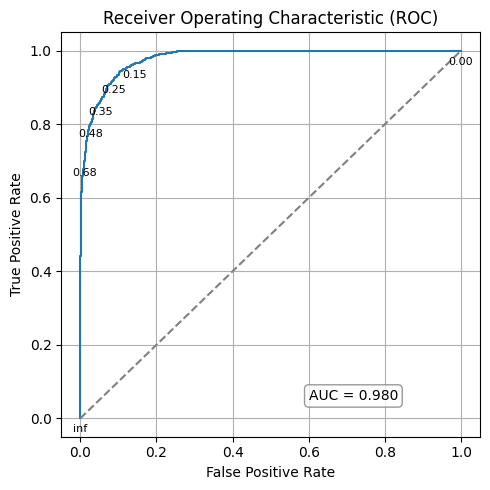

In [ ]:
y_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(5, 5))
plt.plot(fpr, tpr, label=f"ROC curve")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC)")
plt.grid(True)

for i in np.linspace(0, len(thresholds) - 1, 7, dtype=int):
    threshold_val = thresholds[i]
    plt.annotate(f"{threshold_val:.2f}",
                 (fpr[i], tpr[i]),
                 textcoords="offset points",
                 xytext=(0, -10),
                 ha='center',
                 fontsize=8,
                 color='black')
plt.text(
    0.6, 0.05, f"AUC = {roc_auc:.3f}",
    fontsize=10,
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.8)
)

plt.tight_layout()
plt.show()


In [ ]:
y_proba = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

num_points = 7
indices = np.linspace(1, len(thresholds) - 1, num=num_points, dtype=int)

roc_table = pd.DataFrame({
    "Threshold": thresholds[indices],
    "False Positive Rate": fpr[indices],
    "True Positive Rate": tpr[indices]
})

roc_table = roc_table.round(3)
roc_table


,Threshold,False Positive Rate,True Positive Rate
0,1.000,0.000,0.001
1,0.681,0.011,0.699
2,0.476,0.027,0.802
3,0.353,0.053,0.862
4,0.245,0.087,0.921
5,0.146,0.143,0.964
6,0.000,1.000,1.000


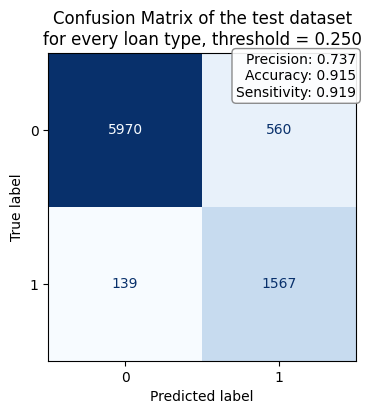

In [ ]:
threshold = 0.25
y_pred = (y_proba >= threshold).astype(int)

cm = confusion_matrix(y_test, y_pred)

precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax, cmap="Blues", colorbar=False)

metrics_text = (
    f"Precision: {precision:.3f}\n"
    f"Accuracy: {accuracy:.3f}\n"
    f"Sensitivity: {sensitivity:.3f}"
)

ax.text(
    1.0, 1.0, metrics_text,
    transform=ax.transAxes,
    fontsize=10,
    va="top",
    ha="right",
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.9)
)

plt.title(f"Confusion Matrix of the test dataset\nfor every loan type, threshold = {threshold:.3f}")
plt.grid(False)
plt.show()


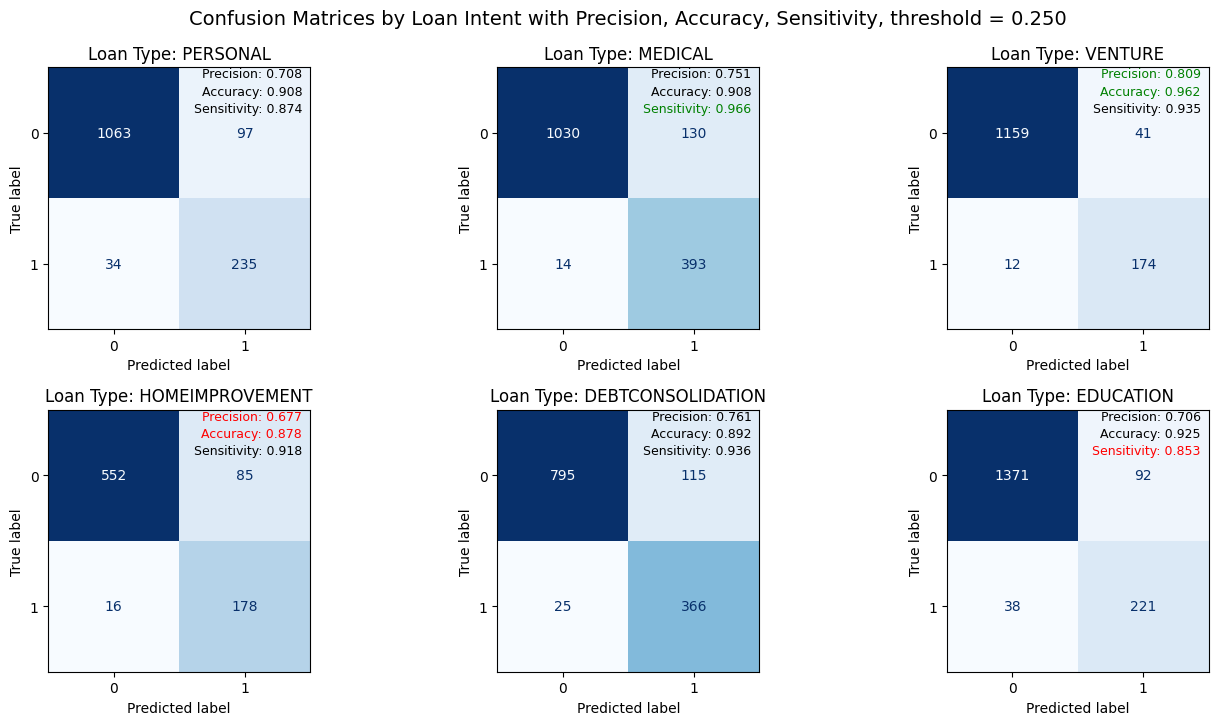

In [ ]:
loan_types = X_test["loan_intent"].unique()

metrics_list = []

for loan_type in loan_types:
    mask = X_test["loan_intent"] == loan_type
    X_subset = X_test[mask]
    y_subset = y_test[mask]

    y_subset_proba = best_model.predict_proba(X_subset)[:, 1]
    y_subset_pred = (y_subset_proba >= threshold).astype(int)

    precision = precision_score(y_subset, y_subset_pred, zero_division=0)
    accuracy = accuracy_score(y_subset, y_subset_pred)
    sensitivity = recall_score(y_subset, y_subset_pred)

    metrics_list.append({
        "loan_type": loan_type,
        "precision": precision,
        "accuracy": accuracy,
        "sensitivity": sensitivity,
        "y_true": y_subset,
        "y_pred": y_subset_pred
    })

metrics_df = pd.DataFrame(metrics_list)

min_vals = metrics_df[["precision", "accuracy", "sensitivity"]].min()
max_vals = metrics_df[["precision", "accuracy", "sensitivity"]].max()

fig, axs = plt.subplots(nrows=2, ncols=(len(loan_types) + 1) // 2, figsize=(14, 7))
axs = axs.flatten()

for i, row in metrics_df.iterrows():
    cm = confusion_matrix(row["y_true"], row["y_pred"])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(ax=axs[i], cmap="Blues", colorbar=False)
    axs[i].set_title(f"Loan Type: {row['loan_type']}")
    axs[i].grid(False)

    def get_color(metric, value):
        if value == min_vals[metric]:
            return "red"
        elif value == max_vals[metric]:
            return "green"
        else:
            return "black"

    metrics = ["precision", "accuracy", "sensitivity"]
    for j, metric in enumerate(metrics):
        axs[i].text(
            0.97,
            1.0 - j * 0.066,
            f"{metric.capitalize()}: {row[metric]:.3f}",
            transform=axs[i].transAxes,
            fontsize=9,
            va="top",
            ha="right",
            color=get_color(metric, row[metric])
        )

plt.tight_layout()
plt.suptitle(f"Confusion Matrices by Loan Intent with Precision, Accuracy, Sensitivity, threshold = {threshold:.3f}", 
             fontsize=14, y=1.03)
plt.show()


In [ ]:
thresholds = np.arange(0.1, 0.6, 0.01) 
loan_types = X_test["loan_intent"].unique()

results = []

for threshold in thresholds:
    for loan_type in loan_types:
        mask = X_test["loan_intent"] == loan_type
        X_subset = X_test[mask]
        y_subset = y_test[mask]

        y_subset_proba = best_model.predict_proba(X_subset)[:, 1]
        y_subset_pred = (y_subset_proba >= threshold).astype(int)

        precision = precision_score(y_subset, y_subset_pred, zero_division=0)

        results.append({
            "threshold": threshold,
            "loan_type": loan_type,
            "precision": precision
        })

results_df = pd.DataFrame(results)

lowest_precision_by_threshold = results_df.loc[
    results_df.groupby("threshold")["precision"].idxmin()
].reset_index(drop=True)

lowest_precision_by_threshold

,threshold,loan_type,precision
0,0.10,EDUCATION,0.490347
1,0.11,EDUCATION,0.510040
2,0.12,EDUCATION,0.523909
3,0.13,EDUCATION,0.540130
4,0.14,EDUCATION,0.562077
5,0.15,EDUCATION,0.592857
6,0.16,EDUCATION,0.601467
7,0.17,HOMEIMPROVEMENT,0.616162
8,0.18,HOMEIMPROVEMENT,0.631944
9,0.19,HOMEIMPROVEMENT,0.636364


In [31]:
lowest_precision_by_threshold["loan_type"].value_counts()

loan_type
HOMEIMPROVEMENT    35
PERSONAL            8
EDUCATION           7
Name: count, dtype: int64

## Comparing against logistic regression

By using a [sample solution](https://www.kaggle.com/code/devraai/bank-loan-analysis-prediction),
we can see that the logistic regression model
achieved ROC of 0.75, while our XGBoost model achieved ROC of 0.98, which is significantly better.
To directly compare the two models, we can use the same threshold for both models.
The threshold is implicitely set to 0.5, but we used different value so far.
Below the confusion matrix can be seend with threshold set to 0.5.
We can see that the false negatives are much lower in our case, and the true negatives are much higher.

The logistic regression model assigned the highest weight to the credit score,
which was our initial assumption, but the XGBoost model assigned the highest weight to the income.

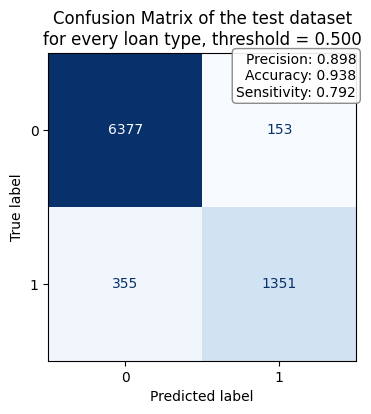

In [32]:
threshold = 0.5
y_pred = (y_proba >= threshold).astype(int)

cm = confusion_matrix(y_test, y_pred)

precision = precision_score(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
sensitivity = recall_score(y_test, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax, cmap="Blues", colorbar=False)

metrics_text = (
    f"Precision: {precision:.3f}\n"
    f"Accuracy: {accuracy:.3f}\n"
    f"Sensitivity: {sensitivity:.3f}"
)

ax.text(
    1.0, 1.0, metrics_text,
    transform=ax.transAxes,
    fontsize=10,
    va="top",
    ha="right",
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.9)
)

plt.title(f"Confusion Matrix of the test dataset\nfor every loan type, threshold = {threshold:.3f}")
plt.grid(False)
plt.show()


# K-means

This time, we need to scale the data, as K-means is sensitive to the scale of the data.
We will use the `StandardScaler` class from the `sklearn.preprocessing` module to scale the data.

The classification is evaluated using the confusion matrix.
Based on the accuracy, sensitivity and sensitivity as quality indicators,
by flipping the labels, not all the indicators got worse or better,
so the outcome is not consistent.


In [33]:
# Drop categorical columns
X_kmeans = loans_c.select_dtypes(include=["int64", "float64"]).drop(columns="loan_status")
print("Used features:", list(X_kmeans.columns))

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_kmeans)

kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)
loans_c["kmeans_cluster"] = clusters

y_true = loans_c["loan_status"]
y_pred = loans_c["kmeans_cluster"]


Used features: ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt', 'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length', 'credit_score']


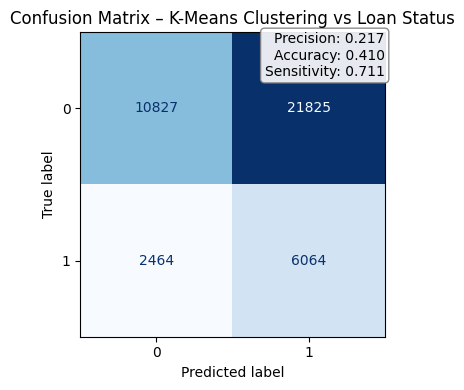

In [34]:
y_true = loans_c["loan_status"]
y_pred = loans_c["kmeans_cluster"]

cm = confusion_matrix(y_true, y_pred)

precision = precision_score(y_true, y_pred, zero_division=0)
accuracy = accuracy_score(y_true, y_pred)
sensitivity = recall_score(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
ax.set_title("Confusion Matrix – K-Means Clustering vs Loan Status")
ax.grid(False)

metrics_text = (
    f"Precision: {precision:.3f}\n"
    f"Accuracy: {accuracy:.3f}\n"
    f"Sensitivity: {sensitivity:.3f}"
)
ax.text(
    1.0, 1.0, metrics_text,
    transform=ax.transAxes,
    fontsize=10,
    va="top",
    ha="right",
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.9),
    color="black"
)

plt.tight_layout()
plt.show()

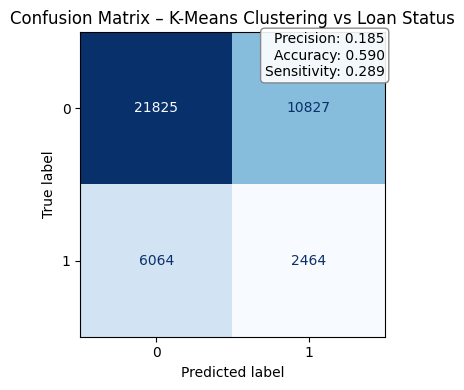

In [35]:
y_pred = 1 - y_pred 

cm = confusion_matrix(y_true, y_pred)

precision = precision_score(y_true, y_pred, zero_division=0)
accuracy = accuracy_score(y_true, y_pred)
sensitivity = recall_score(y_true, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax, cmap="Blues", colorbar=False)
ax.set_title("Confusion Matrix – K-Means Clustering vs Loan Status")
ax.grid(False)

metrics_text = (
    f"Precision: {precision:.3f}\n"
    f"Accuracy: {accuracy:.3f}\n"
    f"Sensitivity: {sensitivity:.3f}"
)
ax.text(
    1.0, 1.0, metrics_text,
    transform=ax.transAxes,
    fontsize=10,
    va="top",
    ha="right",
    bbox=dict(boxstyle="round,pad=0.3", facecolor="white", edgecolor="gray", alpha=0.9),
    color="black"
)

plt.tight_layout()
plt.show()